In [1]:
#gets all this setup
import time
start_time = time.time()
from transformers import BertTokenizer
from pathlib import Path
import torch

from box import Box
import pandas as pd
import collections
import os
from tqdm import tqdm, trange
import sys
import random
import numpy as np
# import apex
from sklearn.model_selection import train_test_split

import datetime

import sys
sys.path.append('../')

from fast_bert.modeling import BertForMultiLabelSequenceClassification
from fast_bert.data_cls import BertDataBunch, InputExample, InputFeatures, MultiLabelTextProcessor, convert_examples_to_features
from fast_bert.learner_cls import BertLearner
# from fast_bert.metrics import accuracy_multilabel, accuracy_thresh, fbeta, roc_auc, accuracy
from fast_bert.metrics import *
import matplotlib.pyplot as plt

torch.cuda.empty_cache()

pd.set_option('display.max_colwidth', -1)
run_start_time = datetime.datetime.today().strftime('%Y-%m-%d_%H-%M-%S')



def create_model(columnm, epoch):
    
    if not os.path.exists('/scratch/da2734/twitter/mturk_mar6/log_{}/'.format(column)):
        os.makedirs('/scratch/da2734/twitter/mturk_mar6/log_{}/'.format(column))

    if not os.path.exists('/scratch/da2734/twitter/mturk_mar6/output_binary_{}'.format(column)):
        os.makedirs('/scratch/da2734/twitter/mturk_mar6/output_binary_{}'.format(column))

    LOG_PATH = Path('/scratch/da2734/twitter/mturk_mar6/log_{}/'.format(column))
    DATA_PATH = Path('/scratch/da2734/twitter/mturk_mar6/data_binary/')
    LABEL_PATH = Path('/scratch/da2734/twitter/mturk_mar6/data_binary/')
    OUTPUT_PATH = Path('/scratch/da2734/twitter/mturk_mar6/output_binary_{}'.format(column))
    FINETUNED_PATH = None

    args = Box({
        "run_text": "labor mturk ar 6 binary",
        "train_size": -1,
        "val_size": -1,
        "log_path": LOG_PATH,
        "full_data_dir": DATA_PATH,
        "data_dir": DATA_PATH,
        "task_name": "labor_market_classification",
        "no_cuda": False,
        #     "bert_model": BERT_PRETRAINED_PATH,
        "output_dir": OUTPUT_PATH,
        "max_seq_length": 512,
        "do_train": True,
        "do_eval": True,
        "do_lower_case": True,
        "train_batch_size": 8,
        "eval_batch_size": 16,
        "learning_rate": 5e-5,
        "num_train_epochs": 100,
        "warmup_proportion": 0.0,
        "no_cuda": False,
        "local_rank": -1,
        "seed": 42,
        "gradient_accumulation_steps": 1,
        "optimize_on_cpu": False,
        "fp16": False,
        "fp16_opt_level": "O1",
        "weight_decay": 0.0,
        "adam_epsilon": 1e-8,
        "max_grad_norm": 1.0,
        "max_steps": -1,
        "warmup_steps": 500,
        "logging_steps": 50,
        "eval_all_checkpoints": True,
        "overwrite_output_dir": True,
        "overwrite_cache": True,
        "seed": 42,
        "loss_scale": 128,
        "task_name": 'intent',
        "model_name": 'bert-base-uncased',
        "model_type": 'bert'
    })

    import logging

    logfile = str(LOG_PATH / 'log-{}-{}.txt'.format(run_start_time, args["run_text"]))

    logging.basicConfig(
        level=logging.INFO,
        format='%(asctime)s - %(levelname)s - %(name)s -   %(message)s',
        datefmt='%m/%d/%Y %H:%M:%S',
        handlers=[
            logging.FileHandler(logfile),
            logging.StreamHandler(sys.stdout)
        ])

    logger = logging.getLogger()

    logger.info(args)

    device = torch.device('cuda')
    if torch.cuda.device_count() > 1:
        args.multi_gpu = True
    else:
        args.multi_gpu = False

    label_cols = ['pos']

    databunch = BertDataBunch(
        args['data_dir'],
        LABEL_PATH,
        args.model_name,
        train_file='train_{}.csv'.format(column),
        val_file='val_{}.csv'.format(column),
        label_file='label_{}.csv'.format(column),
        # test_data='test.csv',
        text_col="text",  # this is the name of the column in the train file that containts the tweet text
        label_col=label_cols,
        batch_size_per_gpu=args['train_batch_size'],
        max_seq_length=args['max_seq_length'],
        multi_gpu=args.multi_gpu,
        multi_label=False,
        model_type=args.model_type)

    num_labels = len(databunch.labels)
    print('num_labels', num_labels)

    print('time taken to load all this stuff:', str(time.time() - start_time), 'seconds')

    # metrics defined: https://github.com/kaushaltrivedi/fast-bert/blob/d89e2aa01d948d6d3cdea7ad106bf5792fea7dfa/fast_bert/metrics.py
    metrics = []
    # metrics.append({'name': 'accuracy_thresh', 'function': accuracy_thresh})
    # metrics.append({'name': 'roc_auc', 'function': roc_auc})
    # metrics.append({'name': 'fbeta', 'function': fbeta})
    metrics.append({'name': 'accuracy', 'function': accuracy})
    metrics.append({'name': 'roc_auc_save_to_plot_binary', 'function': roc_auc_save_to_plot_binary})
    # metrics.append({'name': 'accuracy_multilabel', 'function': accuracy_multilabel})

    learner = BertLearner.from_pretrained_model(
        databunch,
        pretrained_path='../mturk_mar6/output_binary_{}/model_out_{}/'.format(column, epoch), 
        metrics=metrics,
        device=device,
        logger=logger,
        output_dir=args.output_dir,
        finetuned_wgts_path=FINETUNED_PATH,
        warmup_steps=args.warmup_steps,
        multi_gpu=args.multi_gpu,
        is_fp16=args.fp16,
        multi_label=False,
        logging_steps=0)
    
    return learner

is_unemployed
04/04/2020 17:03:37 - INFO - root -   {'run_text': 'labor mturk ar 6 binary', 'train_size': -1, 'val_size': -1, 'log_path': PosixPath('/scratch/da2734/twitter/mturk_mar6/log_is_unemployed'), 'full_data_dir': PosixPath('/scratch/da2734/twitter/mturk_mar6/data_binary'), 'data_dir': PosixPath('/scratch/da2734/twitter/mturk_mar6/data_binary'), 'task_name': 'intent', 'no_cuda': False, 'output_dir': PosixPath('/scratch/da2734/twitter/mturk_mar6/output_binary_is_unemployed'), 'max_seq_length': 512, 'do_train': True, 'do_eval': True, 'do_lower_case': True, 'train_batch_size': 8, 'eval_batch_size': 16, 'learning_rate': 5e-05, 'num_train_epochs': 100, 'warmup_proportion': 0.0, 'local_rank': -1, 'seed': 42, 'gradient_accumulation_steps': 1, 'optimize_on_cpu': False, 'fp16': False, 'fp16_opt_level': 'O1', 'weight_decay': 0.0, 'adam_epsilon': 1e-08, 'max_grad_norm': 1.0, 'max_steps': -1, 'warmup_steps': 500, 'logging_steps': 50, 'eval_all_checkpoints': True, 'overwrite_output_dir': Tr

job_search
04/04/2020 17:06:26 - INFO - root -   {'run_text': 'labor mturk ar 6 binary', 'train_size': -1, 'val_size': -1, 'log_path': PosixPath('/scratch/da2734/twitter/mturk_mar6/log_job_search'), 'full_data_dir': PosixPath('/scratch/da2734/twitter/mturk_mar6/data_binary'), 'data_dir': PosixPath('/scratch/da2734/twitter/mturk_mar6/data_binary'), 'task_name': 'intent', 'no_cuda': False, 'output_dir': PosixPath('/scratch/da2734/twitter/mturk_mar6/output_binary_job_search'), 'max_seq_length': 512, 'do_train': True, 'do_eval': True, 'do_lower_case': True, 'train_batch_size': 8, 'eval_batch_size': 16, 'learning_rate': 5e-05, 'num_train_epochs': 100, 'warmup_proportion': 0.0, 'local_rank': -1, 'seed': 42, 'gradient_accumulation_steps': 1, 'optimize_on_cpu': False, 'fp16': False, 'fp16_opt_level': 'O1', 'weight_decay': 0.0, 'adam_epsilon': 1e-08, 'max_grad_norm': 1.0, 'max_steps': -1, 'warmup_steps': 500, 'logging_steps': 50, 'eval_all_checkpoints': True, 'overwrite_output_dir': True, 'over

job_offer
04/04/2020 17:09:15 - INFO - root -   {'run_text': 'labor mturk ar 6 binary', 'train_size': -1, 'val_size': -1, 'log_path': PosixPath('/scratch/da2734/twitter/mturk_mar6/log_job_offer'), 'full_data_dir': PosixPath('/scratch/da2734/twitter/mturk_mar6/data_binary'), 'data_dir': PosixPath('/scratch/da2734/twitter/mturk_mar6/data_binary'), 'task_name': 'intent', 'no_cuda': False, 'output_dir': PosixPath('/scratch/da2734/twitter/mturk_mar6/output_binary_job_offer'), 'max_seq_length': 512, 'do_train': True, 'do_eval': True, 'do_lower_case': True, 'train_batch_size': 8, 'eval_batch_size': 16, 'learning_rate': 5e-05, 'num_train_epochs': 100, 'warmup_proportion': 0.0, 'local_rank': -1, 'seed': 42, 'gradient_accumulation_steps': 1, 'optimize_on_cpu': False, 'fp16': False, 'fp16_opt_level': 'O1', 'weight_decay': 0.0, 'adam_epsilon': 1e-08, 'max_grad_norm': 1.0, 'max_steps': -1, 'warmup_steps': 500, 'logging_steps': 50, 'eval_all_checkpoints': True, 'overwrite_output_dir': True, 'overwri

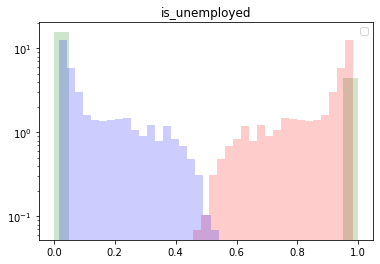

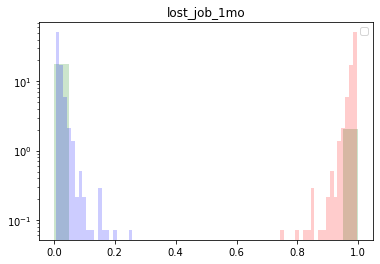

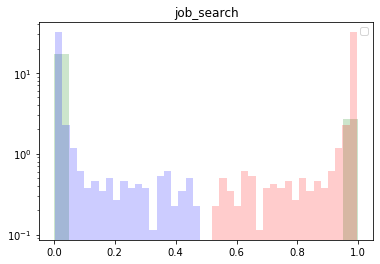

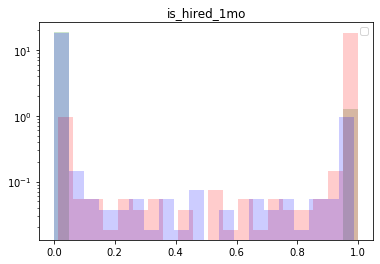

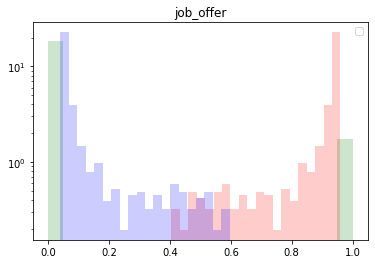

In [2]:
# histograms compute
import pickle
best_epochs = {
    'is_hired_1mo':4,
    'lost_job_1mo':2,
    'job_offer':1,
    'is_unemployed':2,
    'job_search':2
}

all_pred = {}

for column in ["is_unemployed", "lost_job_1mo", "job_search", "is_hired_1mo", "job_offer"]:
    print(column)
    start = time.time()
    trained_model = create_model(column, best_epochs[column])
    print('load model:', str(time.time() - start_time), 'seconds')
    
    start = time.time()
    val = pd.read_csv('/scratch/da2734/twitter/mturk_mar6/data_binary/val_{}.csv'.format(column))
    print(val.shape)
    # start_time = time.time()
    texts = val['text'].values.tolist()
#     print(len(texts))
    predictions = trained_model.predict_batch(texts)
    # predictions.head()
    print('inference:', str(time.time() - start_time), 'seconds on ', len(texts), 'tweets')

    prediction_df = pd.DataFrame(
    [dict(prediction) for prediction in predictions],
        index=val.id
        ).rename(columns={
        'pos':'pos_model',
        'neg':'neg_model',
    #     'is_hired_1mo':'is_hired_1mo_model',
    #     'lost_job_1mo':'lost_job_1mo_model',
    #     'job_offer"':'job_offer_model',
        }
    )
        
    merged = prediction_df.merge(val, on='id')
    print(merged.head())
    
#     break

pickle.dump( all_pred, open( "./all_pred_8.2.pkl", "wb" ) )


is_unemployed
lost_job_1mo
job_search
is_hired_1mo
job_offer


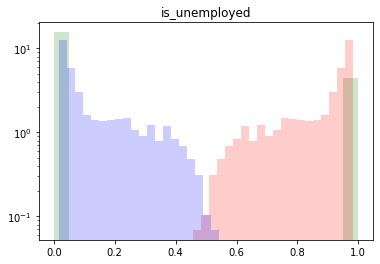

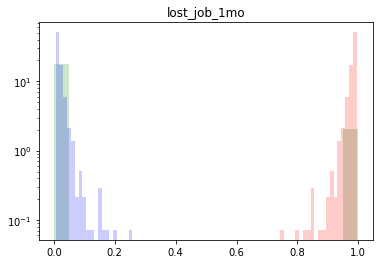

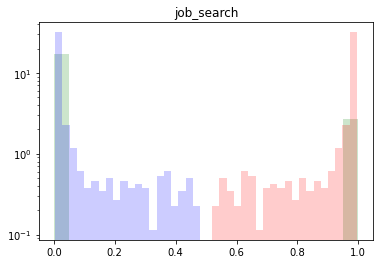

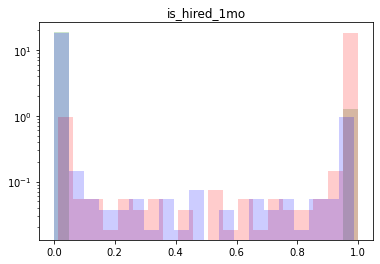

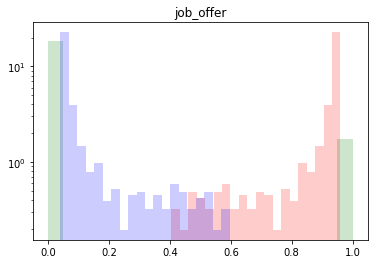

In [6]:
# histograms plot

import pickle

with open("./all_pred_8.2.pkl", 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    all_pred = pickle.load(f)


for column in ["is_unemployed", "lost_job_1mo", "job_search", "is_hired_1mo", "job_offer"]:
    print(column)
    merged = all_pred[column]
    
    fig = plt.figure()
    ax = plt.subplot(111)
    plt.hist(merged['pos'], bins=20, density = True, color = 'green', alpha = 0.2)
    plt.hist(merged['pos_model'], bins=20, density = True, color = 'red', alpha = 0.2)
#     plt.hist(merged['neg'], bins=20, density = True, color = 'green', alpha = 0.2)
    plt.hist(merged['neg_model'], bins=20, density = True, color = 'blue', alpha = 0.2)
    ax.set_yscale('log')

    # plt..yscale(value)
    plt.title(column)
#     ax.legend()

#     plt.savefig('/scratch/da2734/twitter/mturk_mar6/data_binary/plot_{}.png'.format(column))

In [5]:
# preparing ROC using learner.validate()
ROC_dict = {}

best_epochs = {
    'is_hired_1mo':4,
    'lost_job_1mo':2,
    'job_offer':1,
    'is_unemployed':2,
    'job_search':2
}

for column in ["is_unemployed", "lost_job_1mo", "job_search", "is_hired_1mo", "job_offer"]:
    print(column)
    start = time.time()
    trained_model = create_model(column, best_epochs[column])
    print('load model:', str(time.time() - start_time), 'seconds')
    
    start = time.time()
    trained_model.validate()    
#     print(val.shape)
    # start_time = time.time()
#     texts = val['text'].values.tolist()
#     print(len(texts))
#     predictions = trained_model.predict_batch(texts)
    # predictions.head()
    print('validation:', str(time.time() - start_time), 'seconds')   
    
    output = pickle.load( open( "/scratch/da2734/twitter/8-boundary-classified/roc_auc_save_to_plot_binary.pkl", "rb" ) )

    ROC_dict[column] = output
    
#     break

pickle.dump( ROC_dict, open( "./ROC_dict_8.2.pkl", "wb" ) )

is_unemployed
04/04/2020 17:12:27 - INFO - root -   {'run_text': 'labor mturk ar 6 binary', 'train_size': -1, 'val_size': -1, 'log_path': PosixPath('/scratch/da2734/twitter/mturk_mar6/log_is_unemployed'), 'full_data_dir': PosixPath('/scratch/da2734/twitter/mturk_mar6/data_binary'), 'data_dir': PosixPath('/scratch/da2734/twitter/mturk_mar6/data_binary'), 'task_name': 'intent', 'no_cuda': False, 'output_dir': PosixPath('/scratch/da2734/twitter/mturk_mar6/output_binary_is_unemployed'), 'max_seq_length': 512, 'do_train': True, 'do_eval': True, 'do_lower_case': True, 'train_batch_size': 8, 'eval_batch_size': 16, 'learning_rate': 5e-05, 'num_train_epochs': 100, 'warmup_proportion': 0.0, 'local_rank': -1, 'seed': 42, 'gradient_accumulation_steps': 1, 'optimize_on_cpu': False, 'fp16': False, 'fp16_opt_level': 'O1', 'weight_decay': 0.0, 'adam_epsilon': 1e-08, 'max_grad_norm': 1.0, 'max_steps': -1, 'warmup_steps': 500, 'logging_steps': 50, 'eval_all_checkpoints': True, 'overwrite_output_dir': Tr

0.016114397
0.5423005
validation: 623.2749016284943 seconds
lost_job_1mo
04/04/2020 17:13:46 - INFO - root -   {'run_text': 'labor mturk ar 6 binary', 'train_size': -1, 'val_size': -1, 'log_path': PosixPath('/scratch/da2734/twitter/mturk_mar6/log_lost_job_1mo'), 'full_data_dir': PosixPath('/scratch/da2734/twitter/mturk_mar6/data_binary'), 'data_dir': PosixPath('/scratch/da2734/twitter/mturk_mar6/data_binary'), 'task_name': 'intent', 'no_cuda': False, 'output_dir': PosixPath('/scratch/da2734/twitter/mturk_mar6/output_binary_lost_job_1mo'), 'max_seq_length': 512, 'do_train': True, 'do_eval': True, 'do_lower_case': True, 'train_batch_size': 8, 'eval_batch_size': 16, 'learning_rate': 5e-05, 'num_train_epochs': 100, 'warmup_proportion': 0.0, 'local_rank': -1, 'seed': 42, 'gradient_accumulation_steps': 1, 'optimize_on_cpu': False, 'fp16': False, 'fp16_opt_level': 'O1', 'weight_decay': 0.0, 'adam_epsilon': 1e-08, 'max_grad_norm': 1.0, 'max_steps': -1, 'warmup_steps': 500, 'logging_steps': 50,

0.0054487996
0.2579458
validation: 702.6383290290833 seconds
job_search
04/04/2020 17:15:06 - INFO - root -   {'run_text': 'labor mturk ar 6 binary', 'train_size': -1, 'val_size': -1, 'log_path': PosixPath('/scratch/da2734/twitter/mturk_mar6/log_job_search'), 'full_data_dir': PosixPath('/scratch/da2734/twitter/mturk_mar6/data_binary'), 'data_dir': PosixPath('/scratch/da2734/twitter/mturk_mar6/data_binary'), 'task_name': 'intent', 'no_cuda': False, 'output_dir': PosixPath('/scratch/da2734/twitter/mturk_mar6/output_binary_job_search'), 'max_seq_length': 512, 'do_train': True, 'do_eval': True, 'do_lower_case': True, 'train_batch_size': 8, 'eval_batch_size': 16, 'learning_rate': 5e-05, 'num_train_epochs': 100, 'warmup_proportion': 0.0, 'local_rank': -1, 'seed': 42, 'gradient_accumulation_steps': 1, 'optimize_on_cpu': False, 'fp16': False, 'fp16_opt_level': 'O1', 'weight_decay': 0.0, 'adam_epsilon': 1e-08, 'max_grad_norm': 1.0, 'max_steps': -1, 'warmup_steps': 500, 'logging_steps': 50, 'eva

0.0044483137
0.47990277
validation: 783.0014135837555 seconds
is_hired_1mo
04/04/2020 17:16:26 - INFO - root -   {'run_text': 'labor mturk ar 6 binary', 'train_size': -1, 'val_size': -1, 'log_path': PosixPath('/scratch/da2734/twitter/mturk_mar6/log_is_hired_1mo'), 'full_data_dir': PosixPath('/scratch/da2734/twitter/mturk_mar6/data_binary'), 'data_dir': PosixPath('/scratch/da2734/twitter/mturk_mar6/data_binary'), 'task_name': 'intent', 'no_cuda': False, 'output_dir': PosixPath('/scratch/da2734/twitter/mturk_mar6/output_binary_is_hired_1mo'), 'max_seq_length': 512, 'do_train': True, 'do_eval': True, 'do_lower_case': True, 'train_batch_size': 8, 'eval_batch_size': 16, 'learning_rate': 5e-05, 'num_train_epochs': 100, 'warmup_proportion': 0.0, 'local_rank': -1, 'seed': 42, 'gradient_accumulation_steps': 1, 'optimize_on_cpu': False, 'fp16': False, 'fp16_opt_level': 'O1', 'weight_decay': 0.0, 'adam_epsilon': 1e-08, 'max_grad_norm': 1.0, 'max_steps': -1, 'warmup_steps': 500, 'logging_steps': 5

0.0005297582
0.987292
validation: 864.8599894046783 seconds
job_offer
04/04/2020 17:17:48 - INFO - root -   {'run_text': 'labor mturk ar 6 binary', 'train_size': -1, 'val_size': -1, 'log_path': PosixPath('/scratch/da2734/twitter/mturk_mar6/log_job_offer'), 'full_data_dir': PosixPath('/scratch/da2734/twitter/mturk_mar6/data_binary'), 'data_dir': PosixPath('/scratch/da2734/twitter/mturk_mar6/data_binary'), 'task_name': 'intent', 'no_cuda': False, 'output_dir': PosixPath('/scratch/da2734/twitter/mturk_mar6/output_binary_job_offer'), 'max_seq_length': 512, 'do_train': True, 'do_eval': True, 'do_lower_case': True, 'train_batch_size': 8, 'eval_batch_size': 16, 'learning_rate': 5e-05, 'num_train_epochs': 100, 'warmup_proportion': 0.0, 'local_rank': -1, 'seed': 42, 'gradient_accumulation_steps': 1, 'optimize_on_cpu': False, 'fp16': False, 'fp16_opt_level': 'O1', 'weight_decay': 0.0, 'adam_epsilon': 1e-08, 'max_grad_norm': 1.0, 'max_steps': -1, 'warmup_steps': 500, 'logging_steps': 50, 'eval_al

0.039818127
0.5960172
validation: 947.3895146846771 seconds


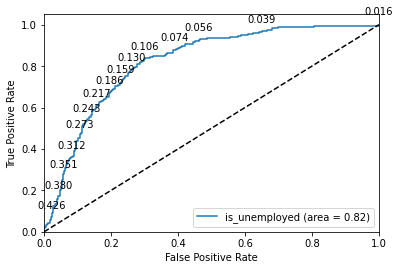

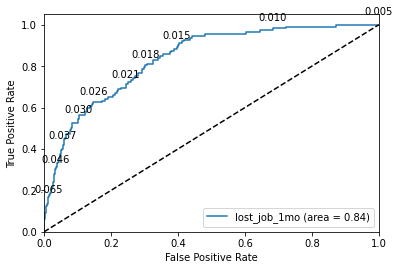

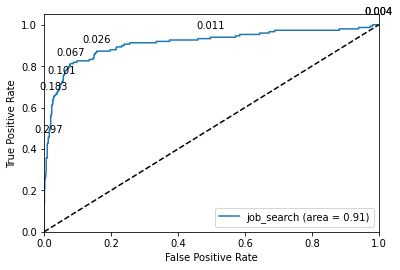

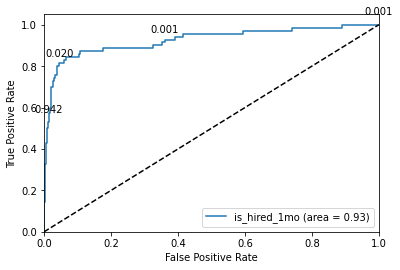

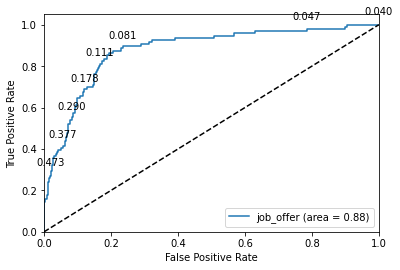

In [7]:
# ROC plot from learner.validate()
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

with open("./ROC_dict_8.2.pkl", 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    ROC_dict = pickle.load(f)

for column in ["is_unemployed", "lost_job_1mo", "job_search", "is_hired_1mo", "job_offer"]:
    
    fpr = ROC_dict[column]['fpr']
#     print(fpr)
    tpr = ROC_dict[column]['tpr']
    thresholds = ROC_dict[column]['thresholds']
#     print(thresholds)
#     print(fpr["micro"])
#     print(len(fpr["micro"]), len(thresholds))
    roc_auc = ROC_dict[column]['roc_auc']

    
    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"], label='{0} (area = {1:0.2f})'
                                   ''.format(column, roc_auc["micro"]))
#     plt.annotate(thresholds, (fpr["micro"], tpr["micro"]))

    count = 0
    for t,x,y in zip(thresholds, fpr["micro"],tpr["micro"]):
#         print(t,x,y)
        count = count + 1

        label = "{:.3f}".format(t)

        if count%20 == 0:
            plt.annotate(label, # this is the text
                     (x,y), # this is the point to label
                     textcoords="offset points", # how to position the text
                     xytext=(0,10), # distance from text to points (x,y)
                     ha='center'
                    ) # horizontal alignment can be left, right or center
    plt.annotate(label, # this is the text
         (x,y), # this is the point to label
         textcoords="offset points", # how to position the text
         xytext=(0,10), # distance from text to points (x,y)
         ha='center'
        ) # horizontal alignment can be left, right or center
    
    plt.plot([0, 1], [0, 1], 'k--') #line y=x
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # plt.title('Some extension of Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")

    plt.show()    

#     break
    

is_unemployed


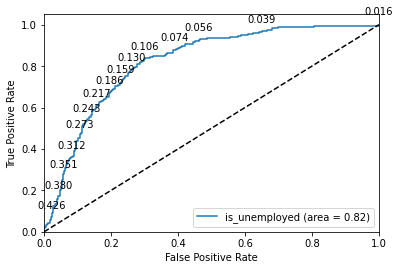

lost_job_1mo


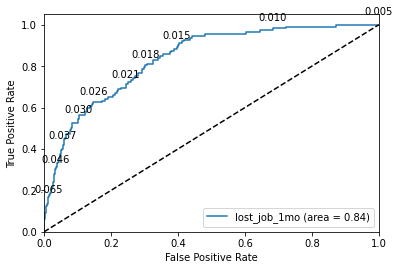

job_search


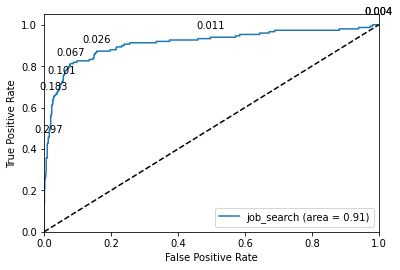

is_hired_1mo


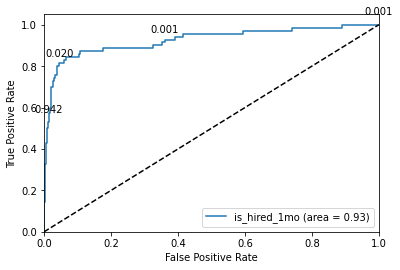

job_offer


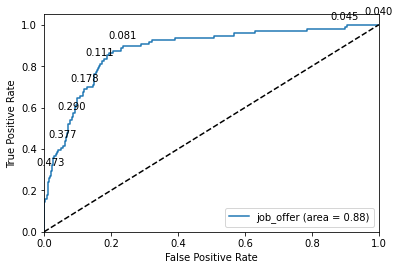

,id,pos_model,neg_model,text,pos
0,4435,0.951538,0.048462,@Salon Imagine @realDonaldTrump singing: You desire a superhero well Im Batman babieeeee. Dont believe me honey? Then youre fired!,0
1,4436,0.955863,0.044137,@SarahPalinUSA Since that dudes been fired Hollywood Libs will call him out because of no fear of being blackballed.,0
2,4437,0.941629,0.058371,Monday Kohls hired me. Tuesday/Wednesday I got a call from Starbucks &amp; got hired after the interview so I quit Kohls.,0
3,4438,0.937484,0.062516,Haha today my dad quit his job then got begged to stay and got a raised and moved up now he has a crew #legit 👌,0
4,4439,0.954656,0.045344,Hired a Mommys Helper to run errands w me tomorrow bc I am a total sellout &amp; quitter.,0


In [20]:
# ROC plot using predicted values on validation set directly i.e. not through validation

import pickle

with open("./all_pred_8.2.pkl", 'rb') as f:
    # The protocol version used is detected automatically, so we do not
    # have to specify it.
    all_pred = pickle.load(f)


for column in ["is_unemployed", "lost_job_1mo", "job_search", "is_hired_1mo", "job_offer"]:
    print(column)
    merged = all_pred[column]

    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    y_true = merged['pos']
    y_pred = merged['neg_model']

#    print(y_true)
    # Compute micro-average ROC curve and ROC area
 
    fpr["micro"], tpr["micro"], thresholds = roc_curve(y_true.ravel(), y_pred.ravel())
#     print('fpr["micro"]', fpr["micro"])
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])


    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"], label='{0} (area = {1:0.2f})'
                                   ''.format(column, roc_auc["micro"]))
    count = 0
    for t,x,y in zip(thresholds, fpr["micro"],tpr["micro"]):
#         print(t,x,y)
        count = count + 1

        label = "{:.3f}".format(t)

        if count%20 == 0:
            plt.annotate(label, # this is the text
                     (x,y), # this is the point to label
                     textcoords="offset points", # how to position the text
                     xytext=(0,10), # distance from text to points (x,y)
                     ha='center'
                    ) # horizontal alignment can be left, right or center
    plt.annotate(label, # this is the text
         (x,y), # this is the point to label
         textcoords="offset points", # how to position the text
         xytext=(0,10), # distance from text to points (x,y)
         ha='center'
        ) # horizontal alignment can be left, right or center
    
    plt.plot([0, 1], [0, 1], 'k--') #line y=x
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # plt.title('Some extension of Receiver operating characteristic to multi-class')
    plt.legend(loc="lower right")

    plt.show()    


#     break
    
merged.head()

is_unemployed 0.16 TPR: 1.0 FPR: 1.0 1101
lost_job_1mo 0.03 TPR: 1.0 FPR: 1.0 1103
job_search 0.067 TPR: 1.0 FPR: 1.0 1107
is_hired_1mo 0.02 TPR: 0.9781576448243114 FPR: 0.9215686274509803 1104
job_offer 0.111 TPR: 1.0 FPR: 1.0 1105


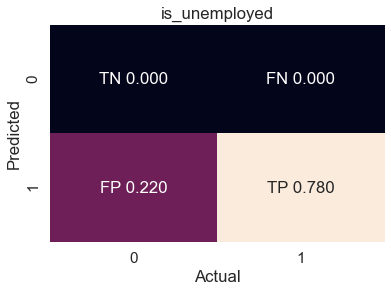

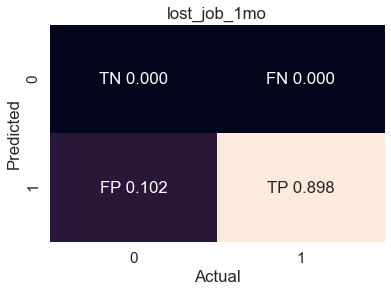

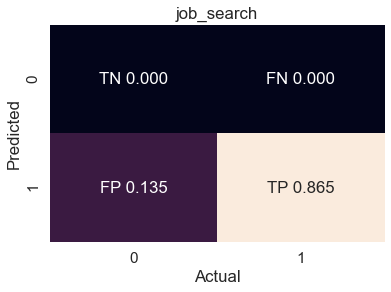

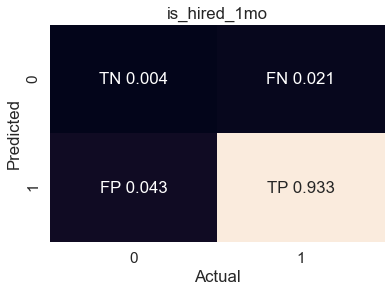

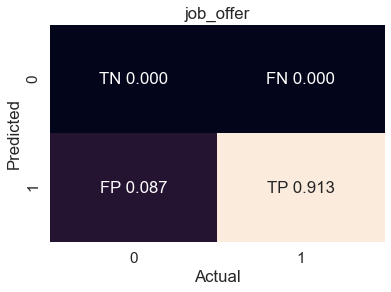

In [24]:
# confusion matrix

import seaborn as sn
from matplotlib.colors import ListedColormap

thresholds_dict = {
    'is_unemployed': 0.16,
    'lost_job_1mo':  0.03,
    'job_search':  0.067,  
    'is_hired_1mo':  0.02,
    'job_offer':     0.111,
}

for column in ["is_unemployed", "lost_job_1mo", "job_search", "is_hired_1mo", "job_offer"]:
# for column in ["job_offer"]:
    merged = all_pred[column]
    merged['neg'] = abs(1-merged['pos'])
#     merged
    threshold = thresholds_dict[column]
#     print(threshold)
    
#     print(merged.loc[merged['pos_model'] > 0.9])
    TP = np.sum(merged.loc[merged['pos_model'] > threshold, 'neg'])
    FP = np.sum(merged.loc[merged['pos_model'] > threshold, 'pos'])
    TN = np.sum(merged.loc[merged['pos_model'] < threshold, 'neg'])
    FN = np.sum(merged.loc[merged['pos_model'] < threshold, 'pos'])
#     TN = np.sum(merged.loc[merged['neg_model'] > threshold, 'neg'])
#     FN = np.sum(merged.loc[merged['neg_model'] > threshold, 'neg'])
    
    total = sum([TP, FP, TN, FN]) 
#     print(threshold, TP/total, FP/total, TN/total, FN/total, total)
    print(column, threshold, 'TPR:', TP/(TP+FN), 'FPR:', FP/(FP+TN), total)

    confusion_matrix = np.array([
                                [TN/total, FN/total],
                                [FP/total, TP/total]
                                ])
    labels =           np.array([
                                ['TN', 'FN'],
                                ['FP', 'TP']
                                ])
    
    labels = (np.asarray(["{0} {1:.3f}".format(string, value)
                      for string, value in zip(labels.flatten(),
                                               confusion_matrix.flatten())])
         ).reshape(2, 2)
#     print(labels)
    
    fig, ax = plt.subplots(1)
    sn.set(font_scale=1.4) # for label size
    sn.heatmap(confusion_matrix, annot=labels, fmt="", cbar=False)
    ax.set(xlabel='Actual', ylabel='Predicted')
    plt.title(column)
    
#     break

# load from pickles
# why am I getting different results between ROC curve and confusion matrices at the same thresholds?

In [45]:
for column in ["is_unemployed", "lost_job_1mo", "job_search", "is_hired_1mo", "job_offer"]:
    model_output = all_pred[column]
    model_output['flip_pos_model'] = model_output['pos_model']
    model_output['flip_neg_model'] = model_output['neg_model']

    neg_sorted = model_output.sort_values(by=['flip_neg_model'], ascending = False)
    pos_sorted = model_output.sort_values(by=['flip_pos_model'], ascending = False)

    print('\n\n\n------ ', column)
    print('<<<< top 10 positive >>>> max prob:', max(model_output['flip_pos_model']))
    print(pos_sorted['text'][:5])
    print('\n<<<< top 10 neg >>>> max prob:', max(model_output['flip_neg_model']))
    print(neg_sorted['text'][:5])

#     break
    
# pos_sorted




------  is_unemployed
<<<< top 10 positive >>>> max prob: 0.983885645866394
141     RT @womenbiznetwork: Ready Set Action! Searching for a New #Job http://t.co/AM52tdIj51 via @ItsJustTami #unemployed               
1097    Looking to get hired? Avoid these pitfalls https://t.co/HBNU1iKQZv tip @LinkedInPulse                                             
675     I am looking for a buyer on 2427 Palisades Place #Mesquite #TX http://t.co/caIVxUKnbI #realestate                                 
919     Looking to Stop Smoking on New Years Day? Try Quit Pro for iPhone http://t.co/CYtoBvsq                                            
1071    I am job searching for: Work at home jobs! http://t.co/4tgcXWg6JK — Walker Inklebarger (@Walker_marocliv... http://t.co/SSfAycUZJ8
Name: text, dtype: object

<<<< top 10 neg >>>> max prob: 0.5423005223274231
750    And now Im unemployed! #winning                       
429    Hell yeah Im unemployed baby daddy down my back       
169    my heart dont work